## Reference 보정을 이용한 AutoML

- Reference 사각형 이미지중 하나를 Base로 잡고, 다른 Reference 이미지들을 다 나누어서 Weight를 구함.
- Weight를 비교할 원본 사각형이미지에 곱해줌
- 곱해진 50x50이미지에 Average RGB값을 구함
- Thickness 를 y 값으로이용해 AutoML Run

In [56]:
import pandas as pd
import numpy as np
from PIL import Image 
import matplotlib.pyplot as plt
import os

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms
import torchvision.models as models
import torch.optim as optim
import torchvision
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
import cv2

In [57]:
Thickness = pd.read_csv('./data/Thickness.csv')
Thickness = Thickness.drop([33]) # 9-1 drop
Thickness.reset_index(drop=True, inplace=True)

top_path = './data/box_img/Top/'
bot_path = './data/box_img/Bot/'

top_path_list = [f'./data/box_img/Top/Top_{i}.jpg' for i in range(0, 127)]
bot_path_list = [f'./data/box_img/Bot/Bot_{i}.jpg' for i in range(0, 127)]

In [58]:
Thickness

,Thickness
0,48.266667
1,47.966667
2,48.166667
3,48.600000
4,59.533333
...,...
122,84.633333
123,98.366667
124,97.033333
125,96.266667


- Reference 보정을 위해 기본값을 정하고 Weight를 줘서 보정을 해주면 되지 않을까?

In [59]:
Base_img = np.array(Image.open(top_path_list[0])) #Ref image(bot) 첫번째를 기본 이미지로 지정
Top_transformed_list = []
for i in range(len(bot_path_list)):
    Bot_transformed = np.array(Image.open(bot_path_list[i]))/np.array(Image.open(bot_path_list[0])) #Ref image(bot) i번째를 첫번째로 나누어서 Weight 값 생성
    Top_transformed = np.array(Image.open(top_path_list[i]))*Bot_transformed #Weight 값과 Top image(top) i번째를 곱하여 Weighted image 생성(보정)
    Top_transformed_list.append(Top_transformed) #Weighted image를 리스트에 추가

In [60]:
Top_transformed_list[0].shape

(50, 50, 3)

### AutoML 먼저 시도

In [61]:
top_avg_rgb = []
for i in range(len(Top_transformed_list)):
    top = Top_transformed_list[i]
    Top_R, Top_G, Top_B = np.mean(top[:,:,0]), np.mean(top[:,:,1]), np.mean(top[:,:,2])
    
    top_avg_rgb.append([Top_R, Top_G, Top_B])

In [62]:
top_avg_rgb = np.array(top_avg_rgb)
top_avg_rgb.shape

(127, 3)

In [63]:
#top avg rgb + thickness
Table_dataset = pd.DataFrame(np.concatenate([top_avg_rgb, Thickness], axis = 1), columns=['R', 'G', 'B', 'Thickness'])
Table_dataset

,R,G,B,Thickness
0,11.576000,10.883200,8.136400,48.266667
1,10.826174,11.729849,9.594695,47.966667
2,13.336985,12.112036,8.233817,48.166667
3,9.354297,9.887613,6.912199,48.600000
4,4.799665,2.776091,1.086510,59.533333
...,...,...,...,...
122,0.503564,4.690656,18.853995,84.633333
123,0.825026,14.850428,27.031939,98.366667
124,0.969714,13.035919,33.905851,97.033333
125,1.159944,13.412763,32.316093,96.266667


In [64]:
X_train, X_test, y_train, y_test = train_test_split(Table_dataset.iloc[:,:-1], Table_dataset.iloc[:,-1], test_size=0.3, random_state=42)

In [65]:
from tpot import TPOTRegressor

tpot =  TPOTRegressor(generations=5, population_size=50, verbosity=2, random_state=42, cv=5, n_jobs = -1)
tpot.fit(X_train, y_train)

tpot.export('tpot_corrected.py')

Optimization Progress:   0%|          | 0/300 [00:00<?, ?pipeline/s]


Generation 1 - Current best internal CV score: -53.46834814108869

Generation 2 - Current best internal CV score: -53.46834814108869

Generation 3 - Current best internal CV score: -51.35804655120336

Generation 4 - Current best internal CV score: -48.66765317278573

Generation 5 - Current best internal CV score: -48.66765317278573

Best pipeline: AdaBoostRegressor(SelectFwe(XGBRegressor(input_matrix, learning_rate=0.01, max_depth=7, min_child_weight=20, n_estimators=100, n_jobs=1, objective=reg:squarederror, subsample=0.6000000000000001, verbosity=0), alpha=0.032), learning_rate=0.5, loss=square, n_estimators=100)


In [66]:
y_pred = tpot.predict(X_test)
y_pred

array([ 72.41428571,  63.01111111,  69.67948718,  97.22727272,
        92.52907801,  65.34333333,  72.11555555,  89.61728395,
        66.12083333, 106.3111111 ,  94.44202899,  62.78888889,
        84.055     ,  64.20476191,  82.09444444, 104.38809523,
        85.79333333,  83.15376344,  68.05072464,  84.055     ,
        67.90333333,  65.34333333,  84.52916667, 153.3       ,
        48.2       , 153.3       , 105.88333333, 104.90000001,
        72.56458333,  84.64416667,  65.31388889,  72.62380952,
        72.56458333, 103.72291666,  91.54137931, 103.77894734,
        69.62857143, 153.3       ,  74.29814815])

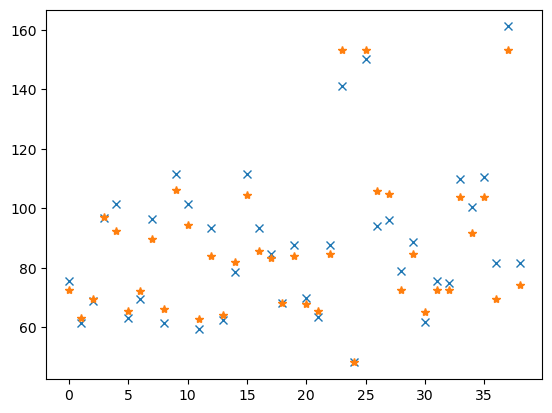

In [67]:
plt.plot(y_test.values,'x', label = 'True')
plt.plot(y_pred,'*', label = 'Predict')

In [68]:
pd.DataFrame({'True': y_test.values, 'Predict': y_pred})

,True,Predict
0,75.533333,72.414286
1,61.300000,63.011111
2,68.700000,69.679487
3,96.633333,97.227273
4,101.466667,92.529078
5,63.166667,65.343333
6,69.433333,72.115556
7,96.266667,89.617284
8,61.466667,66.120833
9,111.533333,106.311111


In [69]:
mse = np.mean((y_test.values - y_pred)**2)
mse

35.573272807034115